## Import Libraries

In [1]:
import pandas as pd
from datetime import datetime

## Read source data

In [146]:
samples = pd.read_csv('./application_samples.csv')

In [147]:
features = pd.read_csv('./credit_features.csv')

In [4]:
data_dict = pd.read_csv('./data_dictionary.csv')

## EDA & Preprocess

### data_dict

In [5]:
data_dict

,Name,Description
0,UID,unique identifier
1,Application Date,Date of loan application
2,Amount,Amount requested by applicant
3,Term,Repayment period requested by applicant
4,Employment Type,Stated employment
5,LoanPurpose,Purpose of loan
6,Success,Applicant successful
7,ALL_AgeOfOldestAccount,Age of oldest accounts
8,ALL_AgeOfYoungestAccount,Age of youngest accounts
9,ALL_Count,No. of accounts


### samples

In [6]:
samples.head()

,UID,ApplicationDate,Amount,Term,EmploymentType,LoanPurpose,Success
0,4921736,03/07/2020,2000,60,Employed - full time,Unexpected bills,0
1,1241981,04/02/2020,3000,60,Employed - full time,Starting new bussniess,0
2,5751748,02/08/2020,20000,60,Employed - full time,Business capital,0
3,7163425,23/09/2020,20000,60,Self employed,New business venture,0
4,227377,01/01/2020,5000,36,Employed - full time,car,0


In [7]:
samples.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8847 entries, 0 to 8846
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   UID              8847 non-null   int64 
 1   ApplicationDate  8847 non-null   object
 2   Amount           8847 non-null   int64 
 3   Term             8847 non-null   int64 
 4   EmploymentType   8847 non-null   object
 5   LoanPurpose      8847 non-null   object
 6   Success          8847 non-null   int64 
dtypes: int64(4), object(3)
memory usage: 483.9+ KB


In [8]:
samples['UID'].nunique()

8847

#### Preprocessing#1 Feature engineering - Object type
ApplicationDate, EmploymentType and LoanPurpose need to be preprocessed since they are the object types which is inappropriate type when we use them as an input of machine learning.
- 'ApplicationDate' : Transform into datetime format, extract year, month, and day as separate columns, extract the day of the week and calculate the number of days since the application date to use all of them as features.
- 'EmploymentType' : Use one-hot encoding which is a basic encoding technique when we have a few unique values in categories
- 'LoanPurpose': Has more than 2,000 different unique values.


In [148]:
# Assuming `ApplicationDate` is in the 'DD/MM/YYYY' format
samples['ApplicationDate'] = pd.to_datetime(samples['ApplicationDate'], format='%d/%m/%Y')

In [149]:
# Extracting year, month, and day as separate columns
# we don't need year since it's just all 2020
# samples['ApplicationYear'] = samples['ApplicationDate'].dt.year
samples['ApplicationMonth'] = samples['ApplicationDate'].dt.month
samples['ApplicationDay'] = samples['ApplicationDate'].dt.day

# Extracting the day of the week (0=Monday, 6=Sunday)
samples['ApplicationDayOfWeek'] = samples['ApplicationDate'].dt.dayofweek

# Calculate the number of days since the application date
current_date = datetime.now()
samples['DaysSinceApplication'] = (current_date - samples['ApplicationDate']).dt.days

In [150]:
samples.drop(columns=['ApplicationDate'], inplace= True)

In [151]:
samples['EmploymentType'].value_counts()

Employed - full time    7714
Employed - part time     570
Self employed            418
Retired                  145
Name: EmploymentType, dtype: int64

In [152]:
samples_1 = pd.get_dummies(samples, columns = ['EmploymentType'])
samples_1.head()

,UID,Amount,Term,LoanPurpose,Success,ApplicationMonth,ApplicationDay,ApplicationDayOfWeek,DaysSinceApplication,EmploymentType_Employed - full time,EmploymentType_Employed - part time,EmploymentType_Retired,EmploymentType_Self employed
0,4921736,2000,60,Unexpected bills,0,7,3,4,1588,1,0,0,0
1,1241981,3000,60,Starting new bussniess,0,2,4,1,1738,1,0,0,0
2,5751748,20000,60,Business capital,0,8,2,6,1558,1,0,0,0
3,7163425,20000,60,New business venture,0,9,23,2,1506,0,0,0,1
4,227377,5000,36,car,0,1,1,2,1772,1,0,0,0


## LoanPurpose 처리해야함

In [14]:
samples_1['LoanPurpose'].nunique()

2444

In [15]:
samples_1['LoanPurpose'].value_counts()

Car                   978
Consolidation         581
car                   373
Debt consolidation    357
Other                 310
                     ... 
Home move               1
the house               1
Home  improvement       1
for the house           1
Wedding deposit         1
Name: LoanPurpose, Length: 2444, dtype: int64

In [16]:
samples['LoanPurpose'].value_counts()[:30]

Car                   978
Consolidation         581
car                   373
Debt consolidation    357
Other                 310
Home improvement      224
Home improvements     221
consolidation         137
debt consolidation    133
home improvements     113
Debt Consolidation    103
New car                90
home improvement       86
Furniture              78
Home Improvments       67
Short Term Loan        65
Debt                   64
other                  59
Car repairs            50
Home Improvements      50
Car purchase           49
Debts                  49
new car                41
Car repair             40
Home Improvement       38
furniture              36
Wedding                36
Home                   33
Car loan               33
Vets bills             32
Name: LoanPurpose, dtype: int64

In [153]:
import re

# First, clean and preprocess the LoanPurpose text data by removing any unnecessary characters, converting text to lowercase, and potentially removing stop words (common words like “the,” “and,” etc.).
samples['LoanPurpose'] = samples['LoanPurpose'].str.lower()
samples['LoanPurpose'] = samples['LoanPurpose'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=100)  # Limiting to top 100 features
loan_purpose_vectors = vectorizer.fit_transform(samples['LoanPurpose'])

In [19]:
from sklearn.cluster import KMeans

# Define the number of clusters (you may need to experiment with this number)
num_clusters = 15
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
samples['LoanPurposeCluster'] = kmeans.fit_predict(loan_purpose_vectors)

In [20]:
import numpy as np

# Get feature names from TF-IDF vectorizer
terms = vectorizer.get_feature_names_out()

# Display top terms for each cluster
for i, center in enumerate(kmeans.cluster_centers_):
    print(f"\nCluster {i} top terms:")
    term_indices = np.argsort(center)[-10:]  # Get indices of top 10 terms
    top_terms = [terms[ind] for ind in term_indices]
    print(top_terms)

AttributeError: 'TfidfVectorizer' object has no attribute 'get_feature_names_out'

In [21]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce dimensions for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(loan_purpose_vectors.toarray())

# Plot the clusters
plt.figure(figsize=(10, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=application_samples['LoanPurposeCluster'], cmap='viridis')
plt.colorbar(label='Cluster')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Loan Purpose Clusters')
plt.show()

NameError: name 'application_samples' is not defined

<Figure size 720x432 with 0 Axes>

In [ ]:
# Example of renaming clusters manually based on inspection
cluster_names = {
    0: 'Essential Expenses',
    1: 'Business Investment',
    # Add other mappings here
}
application_samples['LoanPurposeCluster'] = application_samples['LoanPurposeCluster'].map(cluster_names)

### features

In [154]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8847 entries, 0 to 8846
Data columns (total 14 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   UID                                   8847 non-null   int64  
 1   ALL_AgeOfOldestAccount                8847 non-null   int64  
 2   ALL_AgeOfYoungestAccount              8847 non-null   int64  
 3   ALL_Count                             8847 non-null   int64  
 4   ALL_CountActive                       8847 non-null   int64  
 5   ALL_CountClosedLast12Months           8847 non-null   int64  
 6   ALL_CountDefaultAccounts              8847 non-null   int64  
 7   ALL_CountOpenedLast12Months           8847 non-null   int64  
 8   ALL_CountSettled                      8847 non-null   int64  
 9   ALL_MeanAccountAge                    8847 non-null   float64
 10  ALL_SumCurrentOutstandingBal          8847 non-null   int64  
 11  ALL_SumCurrentOut

In [155]:
# since this column has only one unique value across all rows.
# and it doesn’t provide any useful information for modeling, as it has no variability.
# Dropping it can simplify the dataset without losing any predictive power.
print(features['ALL_TimeSinceMostRecentDefault'].nunique())
features = features.drop(columns=['ALL_TimeSinceMostRecentDefault'])

1


In [156]:
features.describe()

,UID,ALL_AgeOfOldestAccount,ALL_AgeOfYoungestAccount,ALL_Count,ALL_CountActive,ALL_CountClosedLast12Months,ALL_CountDefaultAccounts,ALL_CountOpenedLast12Months,ALL_CountSettled,ALL_MeanAccountAge,ALL_SumCurrentOutstandingBal,ALL_SumCurrentOutstandingBalExcMtg,ALL_WorstPaymentStatusActiveAccounts
count,8.847000e+03,8847.000000,8847.000000,8847.000000,8847.000000,8847.000000,8847.000000,8847.000000,8847.000000,8847.000000,8.847000e+03,8847.000000,8847.000000
mean,4.753101e+06,162.694021,8.587431,17.515316,9.258506,1.589691,1.380355,2.453487,8.231491,57.285159,5.416258e+04,12858.636148,2.057647
std,2.766232e+06,94.569878,13.081866,13.900171,4.896900,2.611921,2.749450,2.964837,11.419963,29.132180,1.074432e+05,17756.568825,3.139938
min,2.160090e+05,-1.000000,-1.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000e+00,-1.000000,-1.000000
25%,2.376933e+06,100.000000,2.000000,9.000000,6.000000,0.000000,0.000000,1.000000,2.000000,38.770000,3.396000e+03,2438.000000,0.000000
50%,4.463541e+06,151.000000,5.000000,15.000000,9.000000,1.000000,0.000000,2.000000,5.000000,53.120000,1.267000e+04,8336.000000,0.000000
75%,7.194733e+06,212.000000,10.000000,22.000000,12.000000,2.000000,2.000000,3.000000,10.000000,71.530000,6.171250e+04,17990.500000,7.000000
max,9.684478e+06,999.000000,258.000000,233.000000,43.000000,60.000000,23.000000,62.000000,215.000000,304.000000,4.004808e+06,581415.000000,7.000000


In [157]:
features['ALL_WorstPaymentStatusActiveAccounts'].nunique()

9

In [158]:
features

,UID,ALL_AgeOfOldestAccount,ALL_AgeOfYoungestAccount,ALL_Count,ALL_CountActive,ALL_CountClosedLast12Months,ALL_CountDefaultAccounts,ALL_CountOpenedLast12Months,ALL_CountSettled,ALL_MeanAccountAge,ALL_SumCurrentOutstandingBal,ALL_SumCurrentOutstandingBalExcMtg,ALL_WorstPaymentStatusActiveAccounts
0,216009,227,12,14,11,0,3,0,3,71.36,9292,9292,7
1,217537,49,10,7,6,1,3,1,1,29.33,4592,4592,7
2,221803,134,0,12,11,0,3,5,1,32.33,2737,2737,7
3,222260,227,2,39,12,0,2,2,27,41.56,9229,9229,7
4,222848,132,2,99,11,8,0,9,88,43.34,15443,15443,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8842,9679857,399,13,23,16,0,0,0,7,118.09,187302,23018,0
8843,9680193,217,23,5,4,0,0,0,1,85.40,264,264,0
8844,9681405,3,1,2,2,0,0,2,0,2.00,0,0,0
8845,9684198,178,15,23,17,0,1,0,6,66.91,10071,10071,7


In [159]:
# make a full_df merging application_samples and features
full_df = pd.merge(samples_1, features, on = 'UID')

In [160]:
full_df

,UID,Amount,Term,LoanPurpose,Success,ApplicationMonth,ApplicationDay,ApplicationDayOfWeek,DaysSinceApplication,EmploymentType_Employed - full time,...,ALL_Count,ALL_CountActive,ALL_CountClosedLast12Months,ALL_CountDefaultAccounts,ALL_CountOpenedLast12Months,ALL_CountSettled,ALL_MeanAccountAge,ALL_SumCurrentOutstandingBal,ALL_SumCurrentOutstandingBalExcMtg,ALL_WorstPaymentStatusActiveAccounts
0,4921736,2000,60,Unexpected bills,0,7,3,4,1588,1,...,18,12,0,0,0,6,70.94,68555,15019,0
1,1241981,3000,60,Starting new bussniess,0,2,4,1,1738,1,...,14,10,0,4,0,4,104.79,2209,2209,7
2,5751748,20000,60,Business capital,0,8,2,6,1558,1,...,4,2,0,1,0,2,68.25,5108,5108,7
3,7163425,20000,60,New business venture,0,9,23,2,1506,0,...,14,6,1,1,0,8,67.50,25738,25738,0
4,227377,5000,36,car,0,1,1,2,1772,1,...,38,19,4,9,8,19,56.45,5801,5801,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8842,8681053,5000,60,Wedding,0,11,17,1,1451,1,...,22,16,2,0,5,6,52.36,10968,10968,0
8843,8768469,8000,24,Wedding,0,11,20,4,1448,1,...,7,4,1,1,0,3,73.57,2204,2204,7
8844,8794971,1000,36,Wedding deposit,0,11,22,6,1446,1,...,14,13,0,0,1,1,44.14,6786,6786,0
8845,8875138,10000,60,Wedding,0,11,24,1,1444,0,...,4,3,1,0,3,1,9.25,9398,9398,0


In [161]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8847 entries, 0 to 8846
Data columns (total 25 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   UID                                   8847 non-null   int64  
 1   Amount                                8847 non-null   int64  
 2   Term                                  8847 non-null   int64  
 3   LoanPurpose                           8847 non-null   object 
 4   Success                               8847 non-null   int64  
 5   ApplicationMonth                      8847 non-null   int64  
 6   ApplicationDay                        8847 non-null   int64  
 7   ApplicationDayOfWeek                  8847 non-null   int64  
 8   DaysSinceApplication                  8847 non-null   int64  
 9   EmploymentType_Employed - full time   8847 non-null   uint8  
 10  EmploymentType_Employed - part time   8847 non-null   uint8  
 11  EmploymentType_Re

In [162]:
# There's no NaN value.
full_df.isna().sum()

UID                                     0
Amount                                  0
Term                                    0
LoanPurpose                             0
Success                                 0
ApplicationMonth                        0
ApplicationDay                          0
ApplicationDayOfWeek                    0
DaysSinceApplication                    0
EmploymentType_Employed - full time     0
EmploymentType_Employed - part time     0
EmploymentType_Retired                  0
EmploymentType_Self employed            0
ALL_AgeOfOldestAccount                  0
ALL_AgeOfYoungestAccount                0
ALL_Count                               0
ALL_CountActive                         0
ALL_CountClosedLast12Months             0
ALL_CountDefaultAccounts                0
ALL_CountOpenedLast12Months             0
ALL_CountSettled                        0
ALL_MeanAccountAge                      0
ALL_SumCurrentOutstandingBal            0
ALL_SumCurrentOutstandingBalExcMtg

In [163]:
full_df

,UID,Amount,Term,LoanPurpose,Success,ApplicationMonth,ApplicationDay,ApplicationDayOfWeek,DaysSinceApplication,EmploymentType_Employed - full time,...,ALL_Count,ALL_CountActive,ALL_CountClosedLast12Months,ALL_CountDefaultAccounts,ALL_CountOpenedLast12Months,ALL_CountSettled,ALL_MeanAccountAge,ALL_SumCurrentOutstandingBal,ALL_SumCurrentOutstandingBalExcMtg,ALL_WorstPaymentStatusActiveAccounts
0,4921736,2000,60,Unexpected bills,0,7,3,4,1588,1,...,18,12,0,0,0,6,70.94,68555,15019,0
1,1241981,3000,60,Starting new bussniess,0,2,4,1,1738,1,...,14,10,0,4,0,4,104.79,2209,2209,7
2,5751748,20000,60,Business capital,0,8,2,6,1558,1,...,4,2,0,1,0,2,68.25,5108,5108,7
3,7163425,20000,60,New business venture,0,9,23,2,1506,0,...,14,6,1,1,0,8,67.50,25738,25738,0
4,227377,5000,36,car,0,1,1,2,1772,1,...,38,19,4,9,8,19,56.45,5801,5801,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8842,8681053,5000,60,Wedding,0,11,17,1,1451,1,...,22,16,2,0,5,6,52.36,10968,10968,0
8843,8768469,8000,24,Wedding,0,11,20,4,1448,1,...,7,4,1,1,0,3,73.57,2204,2204,7
8844,8794971,1000,36,Wedding deposit,0,11,22,6,1446,1,...,14,13,0,0,1,1,44.14,6786,6786,0
8845,8875138,10000,60,Wedding,0,11,24,1,1444,0,...,4,3,1,0,3,1,9.25,9398,9398,0


In [164]:
# Locate y column to the last position of column order
cols_order = list(full_df.columns)[:4] + list(full_df.columns)[5:] + [full_df.columns[4]]
full_df = full_df[cols_order]

In [165]:
full_df

,UID,Amount,Term,LoanPurpose,ApplicationMonth,ApplicationDay,ApplicationDayOfWeek,DaysSinceApplication,EmploymentType_Employed - full time,EmploymentType_Employed - part time,...,ALL_CountActive,ALL_CountClosedLast12Months,ALL_CountDefaultAccounts,ALL_CountOpenedLast12Months,ALL_CountSettled,ALL_MeanAccountAge,ALL_SumCurrentOutstandingBal,ALL_SumCurrentOutstandingBalExcMtg,ALL_WorstPaymentStatusActiveAccounts,Success
0,4921736,2000,60,Unexpected bills,7,3,4,1588,1,0,...,12,0,0,0,6,70.94,68555,15019,0,0
1,1241981,3000,60,Starting new bussniess,2,4,1,1738,1,0,...,10,0,4,0,4,104.79,2209,2209,7,0
2,5751748,20000,60,Business capital,8,2,6,1558,1,0,...,2,0,1,0,2,68.25,5108,5108,7,0
3,7163425,20000,60,New business venture,9,23,2,1506,0,0,...,6,1,1,0,8,67.50,25738,25738,0,0
4,227377,5000,36,car,1,1,2,1772,1,0,...,19,4,9,8,19,56.45,5801,5801,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8842,8681053,5000,60,Wedding,11,17,1,1451,1,0,...,16,2,0,5,6,52.36,10968,10968,0,0
8843,8768469,8000,24,Wedding,11,20,4,1448,1,0,...,4,1,1,0,3,73.57,2204,2204,7,0
8844,8794971,1000,36,Wedding deposit,11,22,6,1446,1,0,...,13,0,0,1,1,44.14,6786,6786,0,0
8845,8875138,10000,60,Wedding,11,24,1,1444,0,0,...,3,1,0,3,1,9.25,9398,9398,0,0


In [166]:
# since we don't need UID anymore for modeling, drop the column
full_df.drop(columns = ['UID'], inplace = True)

/Users/minjoo/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [167]:
full_df.corr()

,Amount,Term,ApplicationMonth,ApplicationDay,ApplicationDayOfWeek,DaysSinceApplication,EmploymentType_Employed - full time,EmploymentType_Employed - part time,EmploymentType_Retired,EmploymentType_Self employed,...,ALL_CountActive,ALL_CountClosedLast12Months,ALL_CountDefaultAccounts,ALL_CountOpenedLast12Months,ALL_CountSettled,ALL_MeanAccountAge,ALL_SumCurrentOutstandingBal,ALL_SumCurrentOutstandingBalExcMtg,ALL_WorstPaymentStatusActiveAccounts,Success
Amount,1.000000,0.572818,0.029164,0.031401,-0.011203,-0.031598,0.043751,-0.065803,-0.029279,0.024760,...,0.014139,-0.063415,-0.276689,-0.121532,-0.051420,0.203860,0.255931,0.162178,-0.339109,-0.108800
Term,0.572818,1.000000,-0.002184,0.010554,-0.003223,0.001421,0.031589,-0.030396,-0.009148,-0.009103,...,0.049809,-0.056075,-0.195510,-0.093158,-0.051929,0.175557,0.159059,0.139849,-0.226917,-0.010138
ApplicationMonth,0.029164,-0.002184,1.000000,0.010458,-0.066650,-0.996680,0.043695,0.020739,0.020856,-0.105299,...,-0.002365,-0.019018,-0.019750,-0.096001,0.002690,0.027759,0.018527,-0.029814,-0.034837,0.039761
ApplicationDay,0.031401,0.010554,0.010458,1.000000,-0.024297,-0.091727,0.022738,-0.006355,-0.006201,-0.024748,...,-0.016984,-0.012130,-0.023916,-0.028271,-0.011261,0.018698,0.019111,0.000420,-0.021584,0.041519
ApplicationDayOfWeek,-0.011203,-0.003223,-0.066650,-0.024297,1.000000,0.068429,0.004471,-0.013305,-0.014484,0.017022,...,-0.022557,-0.007726,0.008833,-0.011124,-0.004215,0.006806,-0.000786,-0.026496,0.011713,0.002102
DaysSinceApplication,-0.031598,0.001421,-0.996680,-0.091727,0.068429,1.000000,-0.044934,-0.020287,-0.020318,0.106405,...,0.003737,0.019892,0.021645,0.097916,-0.001787,-0.029248,-0.020007,0.029625,0.036440,-0.042908
EmploymentType_Employed - full time,0.043751,0.031589,0.043695,0.022738,0.004471,-0.044934,1.000000,-0.684740,-0.336821,-0.581065,...,0.033841,0.057519,-0.007635,0.068777,0.059488,-0.115101,0.020341,0.029995,-0.048769,-0.005450
EmploymentType_Employed - part time,-0.065803,-0.030396,0.020739,-0.006355,-0.013305,-0.020287,-0.684740,1.000000,-0.033875,-0.058439,...,-0.016769,-0.032809,0.010081,-0.030513,-0.033743,0.081880,-0.019070,-0.044452,0.045623,0.028022
EmploymentType_Retired,-0.029279,-0.009148,0.020856,-0.006201,-0.014484,-0.020318,-0.336821,-0.033875,1.000000,-0.028746,...,0.015184,-0.009375,-0.000049,-0.025751,-0.005111,0.096612,-0.028457,-0.021909,0.014075,0.005503
EmploymentType_Self employed,0.024760,-0.009103,-0.105299,-0.024748,0.017022,0.106405,-0.581065,-0.058439,-0.028746,1.000000,...,-0.042982,-0.047016,0.000390,-0.057604,-0.051588,0.028718,0.007060,0.017308,0.015594,-0.027135


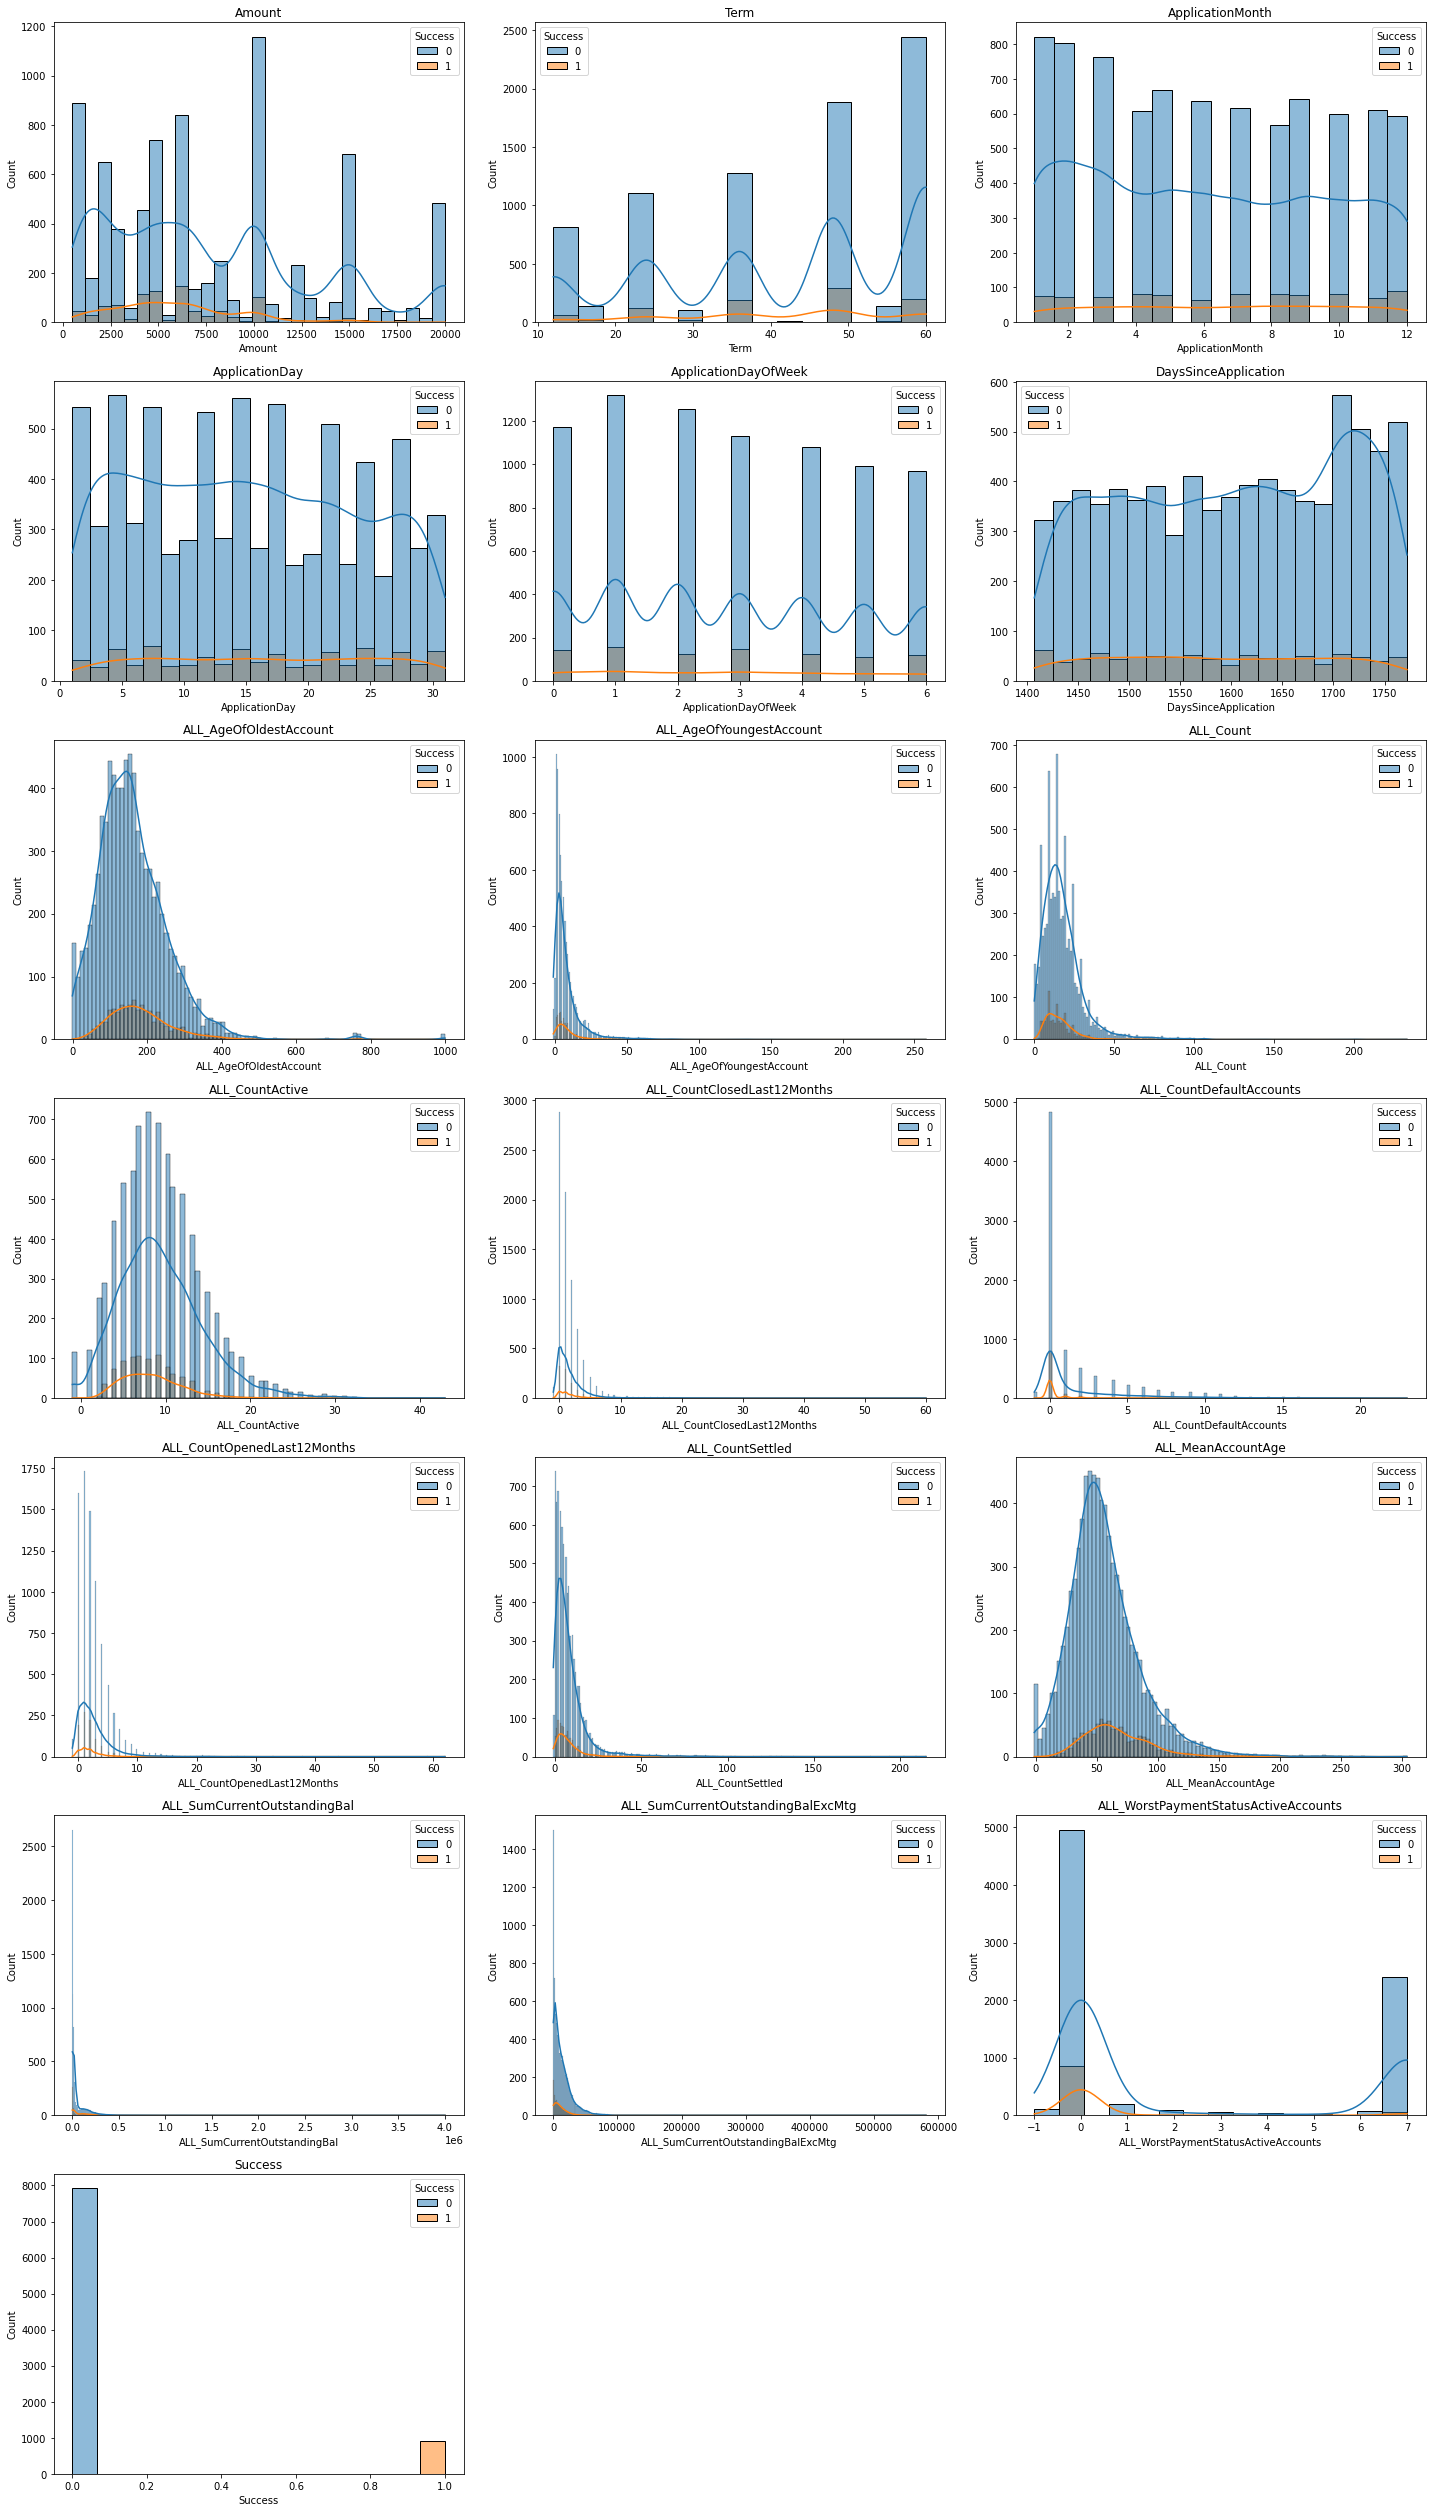

In [169]:
import seaborn as sns
import matplotlib.pyplot as plt

num_features = full_df.select_dtypes(include=['float64', 'int64']).columns

num_plots = len(num_features)
ncols = 3
nrows = (num_plots // ncols) + (num_plots % ncols > 0)

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (20, nrows * 5))
axes = axes.flatten()

for i, feature in enumerate(num_features):
    sns.histplot(data = full_df, x = feature, hue = 'Success', kde = True, ax = axes[i])
    axes[i].set_title(feature)

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [ ]:
# Select the features with filter, ... methods

# 앞에 해결못한 category NLP 해결

# maybe month day 는 categorical 로 변경?

### Preprocessing#2 - Scaling the data

In [34]:
# 모델링 위해 임시로 카테고리 피처 뺌
full_df_ready = full_df.drop(columns = ['LoanPurpose'])

## 스케일러 2가지로 실험해보기
- standard / minmax

In [35]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
num_cols = list(full_df_ready.columns[:-1])

full_df_ready[num_cols] = scaler.fit_transform(full_df_ready[num_cols])

In [36]:
full_df_ready

,Amount,Term,ApplicationYear,ApplicationMonth,ApplicationDay,ApplicationDayOfWeek,DaysSinceApplication,EmploymentType_Employed - full time,EmploymentType_Employed - part time,EmploymentType_Retired,...,ALL_CountActive,ALL_CountClosedLast12Months,ALL_CountDefaultAccounts,ALL_CountOpenedLast12Months,ALL_CountSettled,ALL_MeanAccountAge,ALL_SumCurrentOutstandingBal,ALL_SumCurrentOutstandingBalExcMtg,ALL_WorstPaymentStatusActiveAccounts,Success
0,-1.047440,1.116287,0.0,0.228289,-1.394321,0.599109,-0.108486,0.383244,-0.262422,-0.129085,...,0.559874,-0.608664,-0.502076,-0.827575,-0.195414,0.468747,0.133961,0.121672,-0.655351,0
1,-0.859075,1.116287,0.0,-1.194417,-1.280029,-0.925139,1.285836,0.383244,-0.262422,-0.129085,...,0.151430,-0.608664,0.952843,-0.827575,-0.370556,1.630758,-0.483572,-0.599791,1.574118,0
2,2.343132,1.116287,0.0,0.512830,-1.508613,1.615275,-0.387351,0.383244,-0.262422,-0.129085,...,-1.482349,-0.608664,-0.138346,-0.827575,-0.545697,0.376404,-0.456589,-0.436519,1.574118,0
3,2.343132,1.116287,0.0,0.797371,0.891523,-0.417056,-0.870716,-2.609305,-0.262422,-0.129085,...,-0.665460,-0.225782,-0.138346,-0.827575,-0.020272,0.350658,-0.264569,0.725371,-0.655351,0
4,-0.482345,-0.370863,0.0,-1.478958,-1.622905,-0.417056,1.601882,0.383244,-0.262422,-0.129085,...,1.989431,0.922863,2.771491,1.870871,0.943008,-0.028670,-0.450138,-0.397489,1.574118,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8842,-0.482345,1.116287,0.0,1.366454,0.205770,-0.925139,-1.381967,0.383244,-0.262422,-0.129085,...,1.376764,0.157100,-0.502076,0.858954,-0.195414,-0.169072,-0.402045,-0.106481,-0.655351,0
8843,0.082750,-1.114438,0.0,1.366454,0.548647,0.599109,-1.409854,0.383244,-0.262422,-0.129085,...,-1.073905,-0.225782,-0.138346,-0.827575,-0.458126,0.559030,-0.483618,-0.600073,1.574118,0
8844,-1.235806,-0.370863,0.0,1.366454,0.777231,1.615275,-1.428445,0.383244,-0.262422,-0.129085,...,0.764097,-0.608664,-0.502076,-0.490270,-0.633268,-0.451250,-0.440970,-0.342013,-0.655351,0
8845,0.459480,1.116287,0.0,1.366454,1.005815,-0.925139,-1.447035,-2.609305,-0.262422,-0.129085,...,-1.278127,-0.225782,-0.502076,0.184342,-0.633268,-1.648963,-0.416658,-0.194904,-0.655351,0


In [37]:
target = full_df_ready['Success']
feature_df = full_df_ready.drop(columns = ['Success'])

In [38]:
target.value_counts()

0    7925
1     922
Name: Success, dtype: int64

In [39]:
# Split training and testing data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(feature_df, target,
                                                    shuffle = True, test_size = 0.2, random_state = 42, stratify = target)


# check the train, test data
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7077, 23)
(1770, 23)
(7077,)
(1770,)


## Modeling & Evaluation

In [53]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

In [83]:
def evaluate_model(model, x_test, y_test, desired_precision):

    # predict test data
    y_pred = model.predict(x_test)

    # calculate accuracy, precision, recall, f1-score
    acc = metrics.accuracy_score(y_test, y_pred)
    prec = metrics.precision_score(y_test, y_pred)
    rec = metrics.recall_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred, average = 'weighted')

    # Calculate area under curve (AUC)
    y_pred_proba = model.predict_proba(x_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)

    # Display Confusion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)

    clf_report = pd.DataFrame(metrics.classification_report(y_test, y_pred, output_dict=True)).transpose()

    # Predict probability
    y_prob_test = model.predict_proba(X_test)[:,1]
    precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_prob_test)
    pr_auc = metrics.auc(recall, precision)
    # print('PR-AUC-score : ', pr_auc)


    # desired_precision = 0.8
    for p,r,t in zip(precision, recall, thresholds):
        if p >= desired_precision :
            print(f"Threshold: {t:.2f}, Precision: {p:.2f}, Recall: {r:.2f}")
            selected_threshold = t
            y_pred_adjusted = (y_prob_test >= selected_threshold).astype(int)
            from sklearn.metrics import precision_score, recall_score

            # Calculate precision and recall at the adjusted threshold
            precision_adj = precision_score(y_test, y_pred_adjusted)
            recall_adj = recall_score(y_test, y_pred_adjusted)

            print(f"Adjusted Precision: {precision_adj:.2f}, Adjusted Recall: {recall_adj:.2f}")
            break

    # Plot the Precision-Recall curve
    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision, marker='.', label='PR Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid()
    plt.show()

    # print('Accuracy :', acc)
    print('PR-AUC-score : ', pr_auc)
    print('Precision :', prec)
    print('Recall :', rec)
    print('F1 Score :', f1)
    print('--------------------------------')
    # print('AUC-score :', auc)
    print('Confusion Matrix\n :', cm)
    print('--------------------------------')
    print('Classification Report\n', clf_report)


    # return {'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1,
    #         'fpr': fpr, 'tpr': tpr, 'auc': auc, 'cm': cm, 'report' : clf_report}

In [66]:
# we can try different models & hyperparam tuning
Logistic Regression
Decision trees
Random Forests

GBM
XGBoost
Cat Boost

SyntaxError: invalid syntax (2457426954.py, line 2)

### Logistic Regression

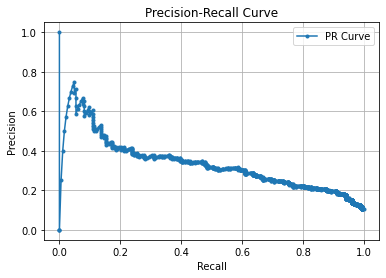

PR-AUC-score :  0.333048793857823
Precision : 0.6521739130434783
Recall : 0.08152173913043478
F1 Score : 0.8635263526352634
--------------------------------
Confusion Matrix
 : [[1578    8]
 [ 169   15]]
--------------------------------
Classification Report
               precision    recall  f1-score  support
0              0.903263  0.994956  0.946895   1586.0
1              0.652174  0.081522  0.144928    184.0
accuracy       0.900000  0.900000  0.900000      0.9
macro avg      0.777718  0.538239  0.545911   1770.0
weighted avg   0.877161  0.900000  0.863526   1770.0


In [87]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(solver = 'liblinear')
lr_clf.fit(X_train, y_train)

# Evaluate
evaluate_model(lr_clf, X_test, y_test, 0.8)

In [88]:
lr_clf = LogisticRegression(solver = 'liblinear')
param_distributions = {'C' : uniform(0.01, 10),
                       'penalty' : ['l1', 'l2']}

lr_clf_cv = RandomizedSearchCV(lr_clf, param_distributions, n_iter = 100, scoring = 'average_precision', cv = 5, random_state = 42, n_jobs =-1)
lr_clf_cv.fit(X_train, y_train)

/Users/minjoo/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/minjoo/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/minjoo/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/minjoo/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/minjoo/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning

RandomizedSearchCV(cv=5, estimator=LogisticRegression(solver='liblinear'),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f8158be5af0>,
                                        'penalty': ['l1', 'l2']},
                   random_state=42, scoring='average_precision')

Threshold: 0.53, Precision: 0.70, Recall: 0.08
Adjusted Precision: 0.70, Adjusted Recall: 0.08


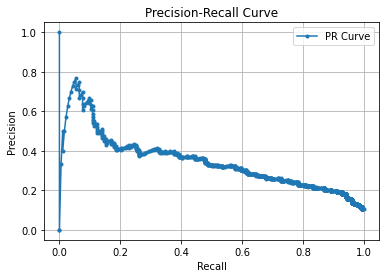

PR-AUC-score :  0.3469355860338508
Precision : 0.64
Recall : 0.08695652173913043
F1 Score : 0.8643483931575069
--------------------------------
Confusion Matrix
 : [[1577    9]
 [ 168   16]]
--------------------------------
Classification Report
               precision    recall  f1-score  support
0              0.903725  0.994325  0.946863   1586.0
1              0.640000  0.086957  0.153110    184.0
accuracy       0.900000  0.900000  0.900000      0.9
macro avg      0.771862  0.540641  0.549986   1770.0
weighted avg   0.876309  0.900000  0.864348   1770.0


In [92]:
# Evaluate
evaluate_model(lr_clf_cv, X_test, y_test, 0.7)

In [121]:
# from sklearn.metrics import accuracy_score
# test_score = accuracy_score(y_test, lr_clf.predict(X_test)) * 100
# train_score = accuracy_score(y_train, lr_clf.predict(X_train)) * 100

# results_df = pd.DataFrame(data=[["Logistic Regression", train_score, test_score]], 
#                           columns=['Model', 'Training Accuracy (%)', 'Testing Accuracy (%)'])
# results_df

,Model,Training Accuracy (%),Testing Accuracy (%)
0,Logistic Regression,89.472941,90.0


### KNN

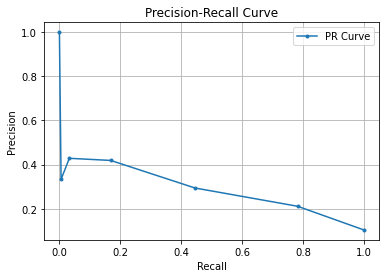

PR-AUC-score :  0.2896774435079401
Precision : 0.4189189189189189
Recall : 0.16847826086956522
F1 Score : 0.8675150490594172
--------------------------------
Confusion Matrix
 : [[1543   43]
 [ 153   31]]
--------------------------------
Classification Report
               precision    recall  f1-score      support
0              0.909788  0.972888  0.940280  1586.000000
1              0.418919  0.168478  0.240310   184.000000
accuracy       0.889266  0.889266  0.889266     0.889266
macro avg      0.664353  0.570683  0.590295  1770.000000
weighted avg   0.858760  0.889266  0.867515  1770.000000


In [90]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)

# Evaluate
evaluate_model(knn_clf, X_test, y_test, 0.8)

In [52]:
knn_clf_cv.best_params_

{'metric': 'manhattan', 'n_neighbors': 28, 'weights': 'distance'}

Adjusted Precision: 0.00, Adjusted Recall: 0.00


/Users/minjoo/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


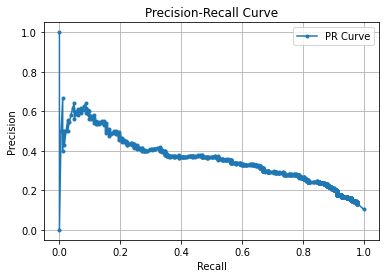

PR-AUC-score :  0.36053021520757256
Precision : 0.6428571428571429
Recall : 0.04891304347826087
F1 Score : 0.857234672132886
--------------------------------
Confusion Matrix
 : [[1581    5]
 [ 175    9]]
--------------------------------
Classification Report
               precision    recall  f1-score      support
0              0.900342  0.996847  0.946140  1586.000000
1              0.642857  0.048913  0.090909   184.000000
accuracy       0.898305  0.898305  0.898305     0.898305
macro avg      0.771599  0.522880  0.518525  1770.000000
weighted avg   0.873575  0.898305  0.857235  1770.000000


In [65]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
param_distributions = {
    'n_neighbors': randint(1, 30),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

knn_clf_cv = RandomizedSearchCV(knn_clf, param_distributions, n_iter = 100, scoring = 'average_precision', cv = 5, random_state = 42, n_jobs =-1)

knn_clf_cv.fit(X_train, y_train)

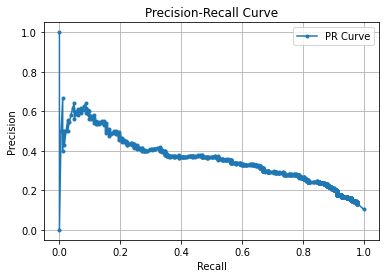

PR-AUC-score :  0.36053021520757256
Precision : 0.6428571428571429
Recall : 0.04891304347826087
F1 Score : 0.857234672132886
--------------------------------
Confusion Matrix
 : [[1581    5]
 [ 175    9]]
--------------------------------
Classification Report
               precision    recall  f1-score      support
0              0.900342  0.996847  0.946140  1586.000000
1              0.642857  0.048913  0.090909   184.000000
accuracy       0.898305  0.898305  0.898305     0.898305
macro avg      0.771599  0.522880  0.518525  1770.000000
weighted avg   0.873575  0.898305  0.857235  1770.000000


In [94]:
# Evaluate
evaluate_model(knn_clf_cv, X_test, y_test, 0.7)

### Decision Tree

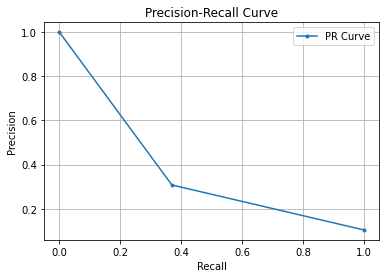

PR-AUC-score :  0.37139712412372694
Precision : 0.3076923076923077
Recall : 0.3695652173913043
F1 Score : 0.8540679401141291
--------------------------------
Confusion Matrix
 : [[1433  153]
 [ 116   68]]
--------------------------------
Classification Report
               precision    recall  f1-score      support
0              0.925113  0.903531  0.914195  1586.000000
1              0.307692  0.369565  0.335802   184.000000
accuracy       0.848023  0.848023  0.848023     0.848023
macro avg      0.616403  0.636548  0.624999  1770.000000
weighted avg   0.860929  0.848023  0.854068  1770.000000


In [96]:
from sklearn import tree

# Decision Tree
dt_clf = tree.DecisionTreeClassifier(random_state= 42)
dt_clf.fit(X_train, y_train)

# Evaluate model
evaluate_model(dt_clf, X_test, y_test, 0.8)

In [77]:
from sklearn import tree

# Decision Tree
dt_clf = tree.DecisionTreeClassifier(random_state= 42)
param_distributions = {'max_depth' : randint(3,10),
                       'min_samples_split' : randint(2,20),
                       'min_samples_leaf' : randint(1,10)}

dt_clf_cv = RandomizedSearchCV(dt_clf, param_distributions, n_iter = 100, scoring = 'average_precision', cv = 5, random_state = 42, n_jobs =-1)
dt_clf_cv.fit(X_train, y_train)


RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f819831dd90>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f8188e3b730>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f81581ee460>},
                   random_state=42, scoring='average_precision')

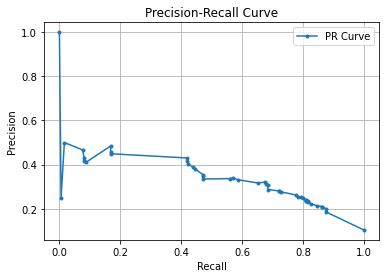

PR-AUC-score :  0.34381812538625955
Precision : 0.42857142857142855
Recall : 0.08152173913043478
F1 Score : 0.859291139463519
--------------------------------
Confusion Matrix
 : [[1566   20]
 [ 169   15]]
--------------------------------
Classification Report
               precision    recall  f1-score     support
0              0.902594  0.987390  0.943089  1586.00000
1              0.428571  0.081522  0.136986   184.00000
accuracy       0.893220  0.893220  0.893220     0.89322
macro avg      0.665583  0.534456  0.540038  1770.00000
weighted avg   0.853317  0.893220  0.859291  1770.00000


In [98]:
# Evaluate model
evaluate_model(dt_clf_cv, X_test, y_test, 0.8)

### Random Forest

Threshold: 0.58, Precision: 0.85, Recall: 0.06
Adjusted Precision: 0.85, Adjusted Recall: 0.06


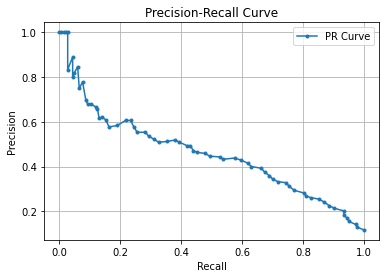

PR-AUC-score :  0.457670352035997
Precision : 0.6571428571428571
Recall : 0.125
F1 Score : 0.8712030006729566
--------------------------------
Confusion Matrix
 : [[1574   12]
 [ 161   23]]
--------------------------------
Classification Report
               precision    recall  f1-score     support
0              0.907205  0.992434  0.947907  1586.00000
1              0.657143  0.125000  0.210046   184.00000
accuracy       0.902260  0.902260  0.902260     0.90226
macro avg      0.782174  0.558717  0.578976  1770.00000
weighted avg   0.881209  0.902260  0.871203  1770.00000


In [99]:
from sklearn.ensemble import RandomForestClassifier

# Building Random Forest model 
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train, y_train)

# Evaluate Model
evaluate_model(rf_clf, X_test, y_test, 0.8)

In [100]:
from sklearn.ensemble import RandomForestClassifier

# Building Random Forest model 
rf_clf = RandomForestClassifier(random_state=0)
param_distributions = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(5, 15),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5)
}

rf_clf_cv = RandomizedSearchCV(rf_clf, param_distributions, n_iter=100, scoring='average_precision', cv=5, random_state=42, n_jobs=-1)
rf_clf_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f8179c15670>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f81991787f0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f8179b41670>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f8199196460>},
                   random_state=42, scoring='average_precision')

Threshold: 0.43, Precision: 0.72, Recall: 0.12
Adjusted Precision: 0.72, Adjusted Recall: 0.12


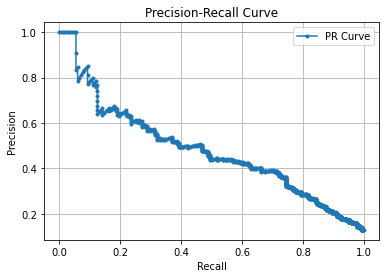

PR-AUC-score :  0.4820471350558013
Precision : 1.0
Recall : 0.02717391304347826
F1 Score : 0.8536815036347177
--------------------------------
Confusion Matrix
 : [[1586    0]
 [ 179    5]]
--------------------------------
Classification Report
               precision    recall  f1-score     support
0              0.898584  1.000000  0.946583  1586.00000
1              1.000000  0.027174  0.052910   184.00000
accuracy       0.898870  0.898870  0.898870     0.89887
macro avg      0.949292  0.513587  0.499747  1770.00000
weighted avg   0.909126  0.898870  0.853682  1770.00000


In [101]:
# Evaluate Model
evaluate_model(rf_clf_cv, X_test, y_test, 0.7)

### GBM

In [102]:
from sklearn.ensemble import GradientBoostingClassifier

# Building Random Forest model 
gbm_clf = GradientBoostingClassifier()
param_distributions = {
    'learning_rate': uniform(0.01, 0.29),
    'n_estimators': randint(50, 300),
    'max_depth': randint(3, 10)
}

gbm_clf_cv = RandomizedSearchCV(gbm_clf, param_distributions, n_iter = 100, scoring = 'average_precision', cv = 5, random_state = 42, n_jobs =-1)
gbm_clf_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f81380812e0>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f8138060790>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f813808bbb0>},
                   random_state=42, scoring='average_precision')

Threshold: 0.57, Precision: 0.70, Recall: 0.17
Adjusted Precision: 0.70, Adjusted Recall: 0.17


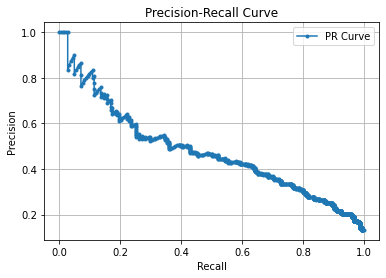

PR-AUC-score :  0.4786932412774965
Precision : 0.6307692307692307
Recall : 0.22282608695652173
F1 Score : 0.8848099844955585
--------------------------------
Confusion Matrix
 : [[1562   24]
 [ 143   41]]
--------------------------------
Classification Report
               precision    recall  f1-score     support
0              0.916129  0.984868  0.949256  1586.00000
1              0.630769  0.222826  0.329317   184.00000
accuracy       0.905650  0.905650  0.905650     0.90565
macro avg      0.773449  0.603847  0.639286  1770.00000
weighted avg   0.886465  0.905650  0.884810  1770.00000


In [103]:
# Evaluate Model
evaluate_model(gbm_clf_cv, X_test, y_test, 0.7)

### XGBoost

Threshold: 0.74, Precision: 0.71, Recall: 0.17
Adjusted Precision: 0.71, Adjusted Recall: 0.17


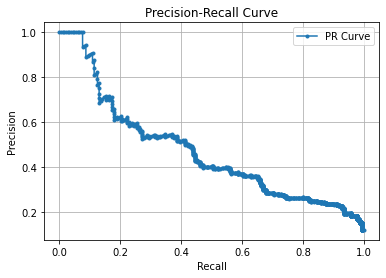

PR-AUC-score :  0.46981019911101685
Precision : 0.5321100917431193
Recall : 0.31521739130434784
F1 Score : 0.8883562774143842
--------------------------------
Confusion Matrix
 : [[1535   51]
 [ 126   58]]
--------------------------------
Classification Report
               precision    recall  f1-score  support
0              0.924142  0.967844  0.945488   1586.0
1              0.532110  0.315217  0.395904    184.0
accuracy       0.900000  0.900000  0.900000      0.9
macro avg      0.728126  0.641531  0.670696   1770.0
weighted avg   0.883388  0.900000  0.888356   1770.0


In [106]:
from xgboost import XGBClassifier

# Building Random Forest model 
xgb_clf = XGBClassifier()
# (n_estimators= 100, max_depth = 1, learning_rate= 1.0, random_state=0)
xgb_clf.fit(X_train, y_train)

# Evaluate Model
evaluate_model(xgb_clf, X_test, y_test, 0.7)

In [112]:
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# Define the parameter distributions for RandomizedSearchCV
param_distributions = {
    'n_estimators': randint(50, 300),            # Randomly choose values between 50 and 300
    'learning_rate': uniform(0.01, 0.3),         # Uniform distribution from 0.01 to 0.3
    'max_depth': randint(3, 10),                 # Randomly choose values between 3 and 10
    'min_child_weight': randint(1, 10),          # Randomly choose values between 1 and 10
    'gamma': uniform(0, 0.5),                    # Uniform distribution from 0 to 0.5
    'subsample': uniform(0.5, 0.5),              # Uniform distribution from 0.5 to 1.0
    'colsample_bytree': uniform(0.3, 0.7),       # Uniform distribution from 0.3 to 1.0
    # 'scale_pos_weight': [scale_pos_weight]       # Use calculated scale_pos_weight for class imbalance
}

# Initialize the XGBClassifier
# xgb_clf = XGBClassifier()

# Set up RandomizedSearchCV with PR-AUC as the scoring metric
xgb_clf_cv = RandomizedSearchCV(
    estimator=XGBClassifier(),
    param_distributions=param_distributions,
    n_iter=100,
    scoring='average_precision',  # Use PR-AUC (average precision) as the scoring metric
    cv=5,
    random_state=42,
    n_jobs=-1
)

# Fit RandomizedSearchCV
xgb_clf_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f81480fd730>,
             

Threshold: 0.61, Precision: 0.82, Recall: 0.12
Adjusted Precision: 0.82, Adjusted Recall: 0.12


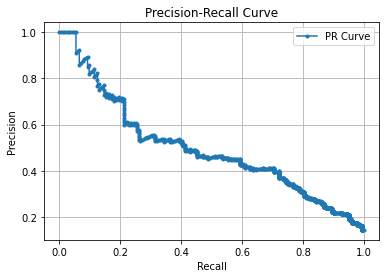

PR-AUC-score :  0.49745617029909184
Precision : 0.6086956521739131
Recall : 0.22826086956521738
F1 Score : 0.8844899730287982
--------------------------------
Confusion Matrix
 : [[1559   27]
 [ 142   42]]
--------------------------------
Classification Report
               precision    recall  f1-score     support
0              0.916520  0.982976  0.948585  1586.00000
1              0.608696  0.228261  0.332016   184.00000
accuracy       0.904520  0.904520  0.904520     0.90452
macro avg      0.762608  0.605618  0.640301  1770.00000
weighted avg   0.884520  0.904520  0.884490  1770.00000


In [114]:
# Evaluate Model
evaluate_model(xgb_clf_cv, X_test, y_test, desired_precision= 0.8)

1. pr-auc score, f1 score 어느정도 되는 모델을 찾기 (GridSearchCV)
2. threshold 조정하여 precision-recall balance

In our case, In lending scenarios, in my personal opinion, i believe the precision is slightly more important to avoid the risk of bad loans. but i am not sure about what your team and organization aims for. if retaining potential customer is a concern, a high recall could also be a valuable option. 
but yea, since i don't really know about the goal, I'd definitely look at F1 score for having safe precision and recall balance.

High precision -> conservative, it's very selective about which applications it predics as successful, but it misses many actual successes.
High precision is valuable if avoiding bad loans is a priority
What's the priority
	•	If the priority is risk minimization (avoiding defaults and reducing financial loss), then a higher precision and lower recall can be justifiable. A conservative threshold (like 0.90) helps ensure that only highly likely successful applicants are approved, aligning with a risk-averse approach.
	•	If the goal includes capturing more successful applicants (e.g., maximizing the loan portfolio’s profitability and retaining customers), then a recall of 0.17 is too low. In this case, you’d want a threshold that balances recall and precision more effectively, as rejecting too many successful applicants could hinder growth.


precision 0.82 : 
recall 0.17 : 

